# Introdução às Redes Neurais Fisicamente Informadas - PINNs (Dia 06) Picture1.jpg

---

Para um número de onda $k_0 = 2\pi n$ com $n = 2$, resolveremos uma equação de Helmholtz:
$$- u_{xx}-u_{yy} - k_0^2 u = f, \qquad \Omega = [0,1]^2$$
com as condições de contorno de Dirichlet
$$u(x,y)=0, \qquad (x,y)\in \partial \Omega$$
e um termo fonte $f(x,y) = k_0^2 \sin(k_0 x)\sin(k_0 y)$.

Neste caso a solução exata é conhecida e dada por:
$$u(x,y)= \sin(k_0 x)\sin(k_0 y)$$

In [ ]:
!pip install deepxde -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.7/183.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.6 MB/s eta 0:00:00


---
Primeiro, os módulos DeepXDE e Numpy são importados:

In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


---
Começamos definindo os parâmetros gerais para o problema. Usamos uma densidade de *collocation points* de 10 (resp. 30) pontos por comprimento de onda para os dados de treinamento (resp. teste) ao longo de cada direção. Este código é para mostrar como se usam as condições de contorno rígidas.

In [ ]:
n = 2
precision_train = 10
precision_test = 30

---
A PINN será treinada com 5000 iterações. Definimos a taxa de aprendizado, o número de camadas densas e nós, e a função de ativação. Além disso, importamos a função seno.

In [ ]:
iterations = 5000
parameters = [1e-3, 3, 150, "sin"]

# Define sine function
sin = tf.sin

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters

---
Em seguida, expressamos o resíduo PDE da equação de Helmholtz:


In [ ]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    f = k0**2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0**2 * y - f

---
O primeiro argumento para EDP é a entrada da rede, ou seja, a coordenada x e a coordenada y. O segundo argumento é a saída da rede, ou seja, a solução u(x), mas aqui usamos y como o nome da variável.

Em seguida, introduzimos a solução exata e a condição de contorno de Dirichlet. Se as condições de contorno forem impostas de forma rígida, aplicamos a seguinte transformação à rede neural: $$\hat{u}(x,y) = x (x-1) y (y-1) \mathcal{N}(x,y)$$

In [ ]:
def func(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])

def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

---
Agora, definimos a geometria e avaliamos o número de pontos de colocação aleatórios de treinamento e teste. Os valores permitem obter densidade de pontos de colocação de 10 (resp. 30) pontos por comprimento de onda ao longo de cada direção. Para condições de contorno suaves, definimos o contorno e as condições de contorno de Dirichlet.

In [ ]:
geom = dde.geometry.Rectangle([0, 0], [1, 1])
k0 = 2 * np.pi * n
wave_len = 1 / n

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

bc = []

---
Em seguida, geramos os pontos de treinamento e teste.

In [ ]:
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=nx_train ** 2,
    num_boundary=4 * nx_train,
    solution=func,
    num_test=nx_test ** 2,
)

---
Em seguida, escolhemos a rede. Aqui, usamos uma rede neural totalmente conectada de profundidade 4 (ou seja, 3 camadas ocultas) e largura 150. Além disso, escolhemos $\sin$ como função de ativação e Glorot uniform como inicializador:

In [ ]:
net = dde.nn.FNN(
  [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

---
Para o caso de restrição rígida, aplicamos a transformação para impor as condições de contorno:

In [ ]:
net.apply_output_transform(transform)

---
Agora, temos o problema e a rede. Construímos um modelo e definimos o otimizador e a taxa de aprendizado. Quando restrições suaves são aplicadas, aplicamos um peso ao termo de contorno para melhorar a convergência para o otimizador `ADAM`:

In [ ]:
model = dde.Model(data, net)

model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.095271 s

'compile' took 2.125106 s



---
Agora treinamos o modelo para 5000 iterações com o otimizador `ADAM`:

In [ ]:
losshistory, train_state = model.train(iterations=iterations)

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.21e+03]    [6.44e+03]    [1.00e+00]    
1000      [5.94e+01]    [7.24e+01]    [3.31e-01]    
2000      [6.61e+00]    [8.27e+00]    [1.05e-01]    
3000      [6.62e-01]    [8.99e-01]    [2.70e-02]    
4000      [3.63e-01]    [4.51e-01]    [9.33e-03]    
5000      [6.89e-02]    [9.54e-02]    [2.96e-03]    

Best model at step 5000:
  train loss: 6.89e-02
  test loss: 9.54e-02
  test metric: [2.96e-03]

'train' took 184.057348 s



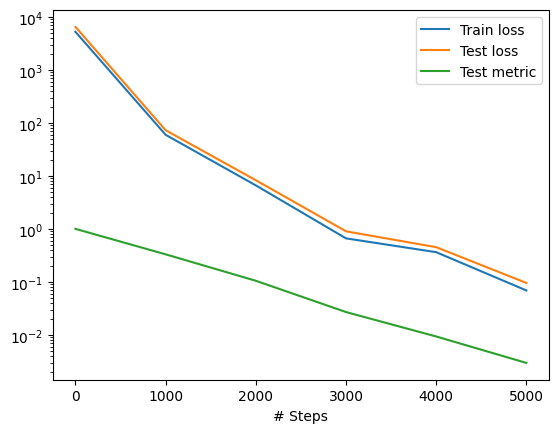

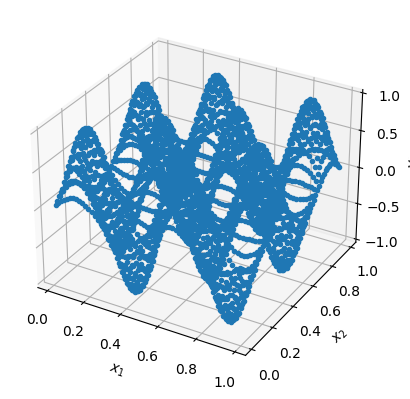

In [ ]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)